In [1]:

%matplotlib inline
from itertools import chain, combinations
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
from abc import ABC
from cmdstanpy import CmdStanModel
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import nest_asyncio
nest_asyncio.apply()
from collections import defaultdict
from typing import Any
import os

from sklearn import metrics
from matplotlib import pyplot as plt
import importlib

/Users/josh/workspace/bayesianquilts/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow_probability.python.bijectors as tfb

# pip install github:https://github.com/mederrata/bayesianquilts
from bayesianquilts.models.logistic_regression_reparam import LogisticRegression2
from bayesianquilts.models.logistic_relunet import ShallowGaussianRelunet
from bayesianquilts.metrics.classification import classification_metrics, auroc, auprc
from bayesianquilts.sampler import psis, nppsis


In [3]:



file_traversable = importlib.resources.files('bayesianquilts').joinpath('data').joinpath('overianx.csv')

# To get an actual file system path (e.g., for libraries that need a string path):
with importlib.resources.as_file(file_traversable) as csv_file_path:
    # Now you can use csv_file_path, for example:
    # print(f"Path to CSV: {csv_file_path}")
    # with open(csv_file_path, 'r') as f:
    #     content = f.read()
    X_ = pd.read_csv(csv_file_path, header=None)
    
file_traversable = importlib.resources.files('bayesianquilts').joinpath('data').joinpath('overiany.csv')

# To get an actual file system path (e.g., for libraries that need a string path):
with importlib.resources.as_file(file_traversable) as csv_file_path:
    # Now you can use csv_file_path, for example:
    # print(f"Path to CSV: {csv_file_path}")
    # with open(csv_file_path, 'r') as f:
    #     content = f.read()
    y_ = pd.read_table(csv_file_path, header=None)


X_scaled = (X_ - X_.mean())/X_.std()
X_scaled = X_scaled.fillna(0).to_numpy()
y_ = y_.to_numpy()
N = X_scaled.shape[0]
d = X_scaled.shape[1]

print((N, d))

(54, 1536)


In [4]:
logistic_relu_horseshoe_code = """
data {
  int<lower=0> N;               // number of observations
  int<lower=0> D_in;            // number of input features
  int<lower=0> D_hidden;        // number of hidden units
  matrix[N, D_in] X;            // input data (N x D_in matrix)
  array[N] int<lower=0, upper=1> y;   // binary target labels (0 or 1)
}

parameters {
  matrix[D_in, D_hidden] w_0;    // weights for the first layer
  vector[D_hidden] b_0;          // biases for the first layer
  
  vector[D_hidden] w_1;          // weights for the output layer
  real b_1;                      // bias for the output layer
}

transformed parameters {
  vector[N] z_output;           // pre-activation output (logits)
  vector[D_hidden] z_hidden;    // hidden layer (latent outputs)
  for (n in 1:N) {
    // Compute hidden layer activations with ReLU
    for (j in 1:D_hidden) {
      z_hidden[j] = X[n] * w_0[, j] + b_0[j];
      z_hidden[j] = fmax(0, z_hidden[j]);  // ReLU activation
    }
    
    // Compute the output logits (before applying sigmoid)
    z_output[n] = dot_product(w_1, z_hidden) + b_1;
  }
}

model {
  // Priors on weights and biases (adjust based on your problem)
  to_vector(w_0) ~ normal(0, 1);
  b_0 ~ normal(0, 1);
  w_1 ~ normal(0, 1);
  b_1 ~ normal(0, 1);

  // Likelihood (logistic sigmoid output)
  y ~ bernoulli_logit(z_output);
}


"""

with open(f"ovarian_relu_model.stan", 'w') as f:
  f.writelines(logistic_relu_horseshoe_code)


In [5]:
!install_cmdstan

CmdStan install directory: /Users/josh/.cmdstan
CmdStan version 2.36.0 already installed
Test model compilation


In [6]:
sm = CmdStanModel(stan_file="ovarian_relu_model.stan")

13:15:44 - cmdstanpy - INFO - compiling stan file /Users/josh/workspace/bayesianquilts/ovarian_relu_model.stan to exe file /Users/josh/workspace/bayesianquilts/ovarian_relu_model
13:15:49 - cmdstanpy - INFO - compiled model executable: /Users/josh/workspace/bayesianquilts/ovarian_relu_model


In [7]:
d_hiden = 3

# shuffle

# shuffled_ndx = np.random.shuffle(np.arange(N))

ovarian_data = {
    "N": N,
    "D_in": d,
    "D_hidden": d_hiden,
    "y": y_.astype(int)[:, 0].tolist(),
    "X": X_scaled.tolist()
}

import json

with open("ovarian_relu_data.json", "w") as f:
    json.dump(ovarian_data, f)

In [8]:
print(d)

1536


In [9]:
S = 2000
if not os.path.isfile('ovarian_relunet_params.npy'):
    fit = sm.sample(
        data="ovarian_relu_data.json",
        iter_warmup=30000,
        iter_sampling=S,
        thin=2,
        # **control
    )
    print(fit)
    print(fit.diagnose())

In [10]:
if not os.path.isfile('ovarian_relunet_params.npy'):
    params = fit.stan_variables()
    {k: p.shape for k, p in params.items()}
    params['b_1'] = params['b_1'][..., tf.newaxis]
    params['w_1'] = params['w_1'][..., tf.newaxis]
    np.save('ovarian_relunet_params.npy', params)
else:
    params = np.load('ovarian_relunet_params.npy', allow_pickle=True).tolist()

In [11]:
nn_model = ShallowGaussianRelunet(
    dim_regressors=d,
    hidden_size=d_hiden
)

In [12]:
params = {k: tf.cast(v, nn_model.dtype) for k, v in params.items()}

In [13]:
tfdata = tf.data.Dataset.from_tensor_slices({'X': X_scaled, 'y':y_})
batch_size = N
def data_factory_factory(batch_size=batch_size, repeat=False, shuffle=False):
    def data_factory(batch_size=batch_size):
        if shuffle:
            out = tfdata.shuffle(batch_size*10)
        else:
            out = tfdata
        
        if repeat:
            out = out.repeat()
        return out.batch(batch_size)
    return data_factory

batch = next(iter(data_factory_factory()()))

1it [00:00,  6.04it/s]2025-05-26 13:15:50.120157: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
1it [00:00,  6.00it/s]


(0.0, 1.0)

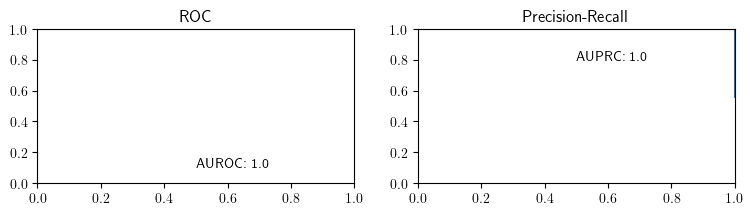

In [14]:
def prediction_fn(data):
    pred = nn_model.predictive_distribution(data, **params)["logits"][..., 1]
    return tf.reduce_mean(pred, axis=0)

bench = classification_metrics(
    data_factory=data_factory_factory(),
    prediction_fn=prediction_fn,
    outcome_label='y',
    by_vars=[]
)

fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(bench['auroc']['fpr'], bench['auroc']['tpr'])
ax[0].text(0.5, 0.1, f"AUROC: {round(bench['auroc']['auroc'], 2)}")
ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(bench['auprc']['recall'], bench['auprc']['precision'])
ax[1].text(0.5, 0.8, f"AUPRC: {round(bench['auprc']['auprc'], 2)}")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

In [15]:
def entropy(probs):
    return -tf.math.xlogy(probs, probs)


def heaviside(x):
    out = tf.where(x > 0, tf.ones_like(x), tf.zeros_like(x))
    return out


def adaptive_is_loo(
    self: ShallowGaussianRelunet,
    data: dict[str, tf.Tensor],
    params,
    hbar=1.0,
    variational=True,
    approx_jacobians=True,
) -> dict[str, Any]:
    """_summary_

    Args:
        data (_type_): _description_
        params (_type_): _description_
        hbar (float, optional): _description_. Defaults to 1.0.
        variational (bool, optional):
            Should we trust the variational approximation?
            If False, assumes that one is passing in all the data at once in a single batch.
            Defaults to True.

    Returns:
        _type_: _description_
    """

    # scaled (theta - bar(theta))/Sigma

    _X = tf.cast(data["X"], self.dtype)
    _y = tf.cast(data["y"], self.dtype)[:, 0]
    mu = self.eval(_X, params)[..., 0]
    sigma = tf.math.sigmoid(mu)
    ell = _y * (sigma) + (1 - _y) * (1 - sigma)
    log_ell = tf.math.xlogy(_y, sigma) + tf.math.xlogy(1 - _y, 1 - sigma)
    log_ell_prime = _y * (1 - sigma) - (1 - _y) * sigma
    log_ell_doubleprime = -sigma * (1 - sigma)
    _, khat0 = nppsis.psislw(-log_ell)

    """
    sigma.shape is samples x datapoints
    """

    ndx_to_transform = np.where(khat0 > 0.7)[0]
    ndx_to_leave = np.where((khat0 <= 0.7))[0]

    def IS(T, X, y):
        mu = self.eval(X, params)[..., 0]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)
        log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
        log_ell_prime = y * (1 - sigma) - (1 - y) * sigma
        log_ell_doubleprime = -sigma * (1 - sigma)
        # compute # \nabla\log\pi(\btheta|\calD)
        if variational:
            # \nabla\log\pi = -\Sigma^{-1}(theta - \bar{\theta})
            grad_log_pi = {
                "b_0": -(
                    params["b_0"] - self.surrogate_distribution.model["b_0"].mean()
                )
                / self.surrogate_distribution.model["b_0"].variance(),
                "b_1": -(
                    params["b_1"] - self.surrogate_distribution.model["b_1"].mean()
                )
                / self.surrogate_distribution.model["b_1"].variance(),
                "w_0": -(
                    params["w_0"] - self.surrogate_distribution.model["w_0"].mean()
                )
                / self.surrogate_distribution.model["w_0"].variance(),
                "w_1": -(
                    params["w_1"] - self.surrogate_distribution.model["w_1"].mean()
                )
                / self.surrogate_distribution.model["w_1"].variance(),
            }
            b0_sd = self.surrogate_distribution.model["b_0"].variance() ** 0.5
            b1_sd = self.surrogate_distribution.model["b_1"].variance() ** 0.5
            w0_sd = self.surrogate_distribution.model["w_0"].variance() ** 0.5
            w1_sd = self.surrogate_distribution.model["w_1"].variance() ** 0.5
            log_pi = (
                self.surrogate_distribution.model["b_0"].log_prob(params["b_0"])
                + self.surrogate_distribution.model["b_1"].log_prob(params["b_1"])
                + self.surrogate_distribution.model["w_1"].log_prob(params["w_1"])
                + self.surrogate_distribution.model["w_0"].log_prob(params["w_0"])
            )
            log_pi -= tf.reduce_max(log_pi, axis=0)
            # log_pi.shape: [samples]
        else:
            """
            Recall Bayes rule:
            \log pi(\btheta|\calD) = \sum_i\log ell_i(\btheta) + \log\pi(\btheta) + const

            so
            \nabla\log\pi(\btheta|\calD) = \sum_i (ell_i)'x + grad\log\pi(\btheta)

            """
            log_prior = self.prior_distribution.log_prob(params)

            log_pi = tf.reduce_sum(log_ell, axis=1, keepdims=True)[:, 0]
            z1 = tf.nn.relu(tf.matmul(X, params["w_0"]))
            # pi \propto #@TODO

            grad_log_pi = {
                "b_0": (
                    tf.reduce_sum(
                        (
                            params["w_1"][..., tf.newaxis, :, :]
                            * log_ell_prime[..., tf.newaxis, tf.newaxis]
                        )
                        * heaviside(z1)[..., tf.newaxis],
                        axis=1,
                        keepdims=False,
                    )[..., 0]
                    - 0.5 * params["b_0"] ** 2
                ),
                "b_1": tf.reduce_sum(
                    log_ell_prime[..., tf.newaxis], axis=1, keepdims=False
                )
                - 0.5 * params["b_1"] ** 2,
                "w_0": (
                    tf.reduce_sum(
                        (
                            (
                                params["w_1"][..., tf.newaxis, :, :]
                                * log_ell_prime[..., tf.newaxis, tf.newaxis]
                                * heaviside(z1)[..., tf.newaxis]
                            )[..., tf.newaxis, :, 0]
                            * X[..., tf.newaxis]
                        ),
                        axis=1,
                        keepdims=False,
                    )  # want S x N x k
                    - 0.5 * params["w_0"] ** 2
                ),
                "w_1": tf.reduce_sum(
                    log_ell_prime[..., tf.newaxis, tf.newaxis] * z1[..., tf.newaxis],
                    axis=1,
                    keepdims=False,
                )
                - 0.5 * params["w_1"] ** 2,
            }

            grad_log_prior = {
                "b_0": -0.5 * params["b_0"] ** 2
                - 0.5 * tf.cast(tf.math.sqrt(2 * np.pi), self.dtype),
                "b_1": -0.5 * params["b_1"] ** 2
                - 0.5 * tf.cast(tf.math.sqrt(2 * np.pi), self.dtype),
                "w_0": -0.5 * params["w_0"] ** 2
                - 0.5 * tf.cast(tf.math.sqrt(2 * np.pi), self.dtype),
                "w_1": -0.5 * params["w_1"] ** 2
                - 0.5 * tf.cast(tf.math.sqrt(2 * np.pi), self.dtype),
            }
            # grad_log_pi += grad_log_prior[:, tf.newaxis, :]

            b0_sd = tf.math.reduce_std(params["b_0"], 0, keepdims=True)
            b1_sd = tf.math.reduce_std(params["b_1"], 0, keepdims=True)
            w0_sd = tf.math.reduce_std(params["w_0"], 0, keepdims=True)
            w1_sd = tf.math.reduce_std(params["w_1"], 0, keepdims=True)

        b0_adj, b1_adj, w0_adj, w1_adj, logJ = T(
            X,
            y,
            log_pi=log_pi,
            grad_log_pi=grad_log_pi,
            b0_sd=b0_sd,
            b1_sd=b1_sd,
            w0_sd=w0_sd,
            w1_sd=w1_sd,
        )
        transformed = {"b_0": b0_adj, "b_1": b1_adj, "w_0": w0_adj, "w_1": w1_adj}
        mu_new = self.nn.eval(X[:, tf.newaxis, :], [w0_adj, b0_adj, w1_adj, b1_adj])[
            ..., 0, 0
        ]
        sigma_new = tf.math.sigmoid(mu_new)
        ell_new = y * (sigma_new) + (1 - y) * (1 - sigma_new)
        log_ell_new = tf.math.xlogy(y, sigma_new) + tf.math.xlogy(1 - y, 1 - sigma_new)

        if variational:
            # We trust the variational approximation, so \hat{pi} = pi
            # N_samples x N_data
            delta_log_pi = (
                self.surrogate_distribution.log_prob(transformed)
                - log_pi[:, tf.newaxis]
            )
            delta_log_pi = delta_log_pi - tf.reduce_max(
                delta_log_pi, axis=0, keepdims=True
            )

        else:
            # we don't trust the variational approximation
            # Need to compute log_pi directly by summing over the likelihood

            ell_cross = tf.math.sigmoid(
                self.nn.eval(X, [w0_adj, b0_adj, w1_adj, b1_adj])[..., 0]
            )
            ell_cross = tf.math.xlogy(y, ell_cross) + tf.math.xlogy(
                1 - y, 1 - ell_cross
            )
            ell_cross = tf.math.reduce_sum(ell_cross, axis=-1)

            log_prior_new = self.prior_distribution.log_prob(transformed)

            log_pi_new = ell_cross
            delta_log_prior = log_prior_new - log_prior[:, tf.newaxis]
            # Incorporate the prior
            delta_log_pi = log_pi_new - log_pi[:, tf.newaxis] + delta_log_prior

        # regularize delta_log_pi

        def regularize(tensor):
            min_finite = tf.reduce_min(
                tf.where(
                    tf.math.is_finite(tensor),
                    tensor,
                    tf.zeros_like(tensor),
                )
            )
            return tf.where(
                tf.math.is_finite(tensor),
                tensor,
                min_finite * tf.ones_like(tensor),
            )

        delta_log_pi = regularize(delta_log_pi)
        delta_log_pi -= tf.reduce_max(delta_log_pi, axis=0)
        log_eta_weights = delta_log_pi - regularize(log_ell_new) + logJ
        log_eta_weights = log_eta_weights - tf.reduce_max(log_eta_weights, axis=0)
        psis_weights, khat = nppsis.psislw(log_eta_weights)

        eta_weights = tf.math.exp(log_eta_weights)
        eta_weights = eta_weights / tf.reduce_sum(eta_weights, axis=0, keepdims=True)

        psis_weights = tf.math.exp(psis_weights)
        psis_weights = psis_weights / tf.math.reduce_sum(
            psis_weights, axis=0, keepdims=True
        )

        weight_entropy = entropy(eta_weights)
        psis_entropy = entropy(psis_weights)

        p_loo_new = tf.reduce_sum(sigma_new * eta_weights, axis=0)
        p_loo_psis = tf.reduce_sum(sigma_new * psis_weights, axis=0)
        p_loo_sd = tf.math.reduce_std(sigma_new * eta_weights, axis=0)
        ll_loo_new = tf.reduce_sum(eta_weights * ell_new, axis=0)
        ll_loo_psis = tf.reduce_sum(psis_weights * ell_new, axis=0)
        ll_loo_sd = tf.math.reduce_std(eta_weights * ell_new, axis=0)
        out = (
            eta_weights,
            psis_weights,
            p_loo_new,
            p_loo_sd,
            ll_loo_new,
            ll_loo_sd,
            weight_entropy,
            khat,
            p_loo_psis,
            ll_loo_psis,
        )
        return out

    def T_kl(X, y, log_pi, grad_log_pi, b0_sd, b1_sd, w0_sd, w1_sd, **kwargs):
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        mu = self.eval(X, params)[..., 0]
        sigma = tf.math.sigmoid(mu)
        pre = ((-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ]
        z1 = tf.nn.relu(tf.matmul(X, params["w_0"]))
        Q_b1 = pre
        Q_w1 = (pre * z1)[..., tf.newaxis]
        Q_b0 = (
            pre[..., tf.newaxis]
            * heaviside(z1)[..., tf.newaxis]
            * params["w_1"][..., tf.newaxis, :, :]
        )
        Q_w0 = (
            pre[..., tf.newaxis, :]
            * heaviside(z1)[..., tf.newaxis, :]
            * X[..., tf.newaxis]
            * params["w_1"][..., tf.newaxis, tf.newaxis, :, 0]
        )

        standardized = tf.concat(
            [
                tf.reduce_max(tf.math.abs(Q_b0 / tf.transpose(b0_sd)), axis=-1),
                tf.math.abs(Q_b1 / b1_sd),
                tf.reduce_max(tf.math.abs(Q_w0 / w0_sd), axis=-1),
                (Q_w1 / w1_sd)[..., 0],
            ],
            axis=-1,
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        b0_adj = params["b_0"][..., tf.newaxis, :] + h * Q_b0[..., 0]
        b1_adj = params["b_1"][..., tf.newaxis, :] + h * Q_b1
        w0_adj = params["w_0"][..., tf.newaxis, :, :] + h[..., tf.newaxis] * Q_w0
        w1_adj = params["w_1"][..., tf.newaxis, :, :] + h[..., tf.newaxis] * Q_w1

        eigen_plus = tf.reduce_sum(
            heaviside(z1)[..., tf.newaxis] * X[:, tf.newaxis] ** 2, axis=-1
        )
        eigen_plus = tf.math.sqrt(eigen_plus)

        u_k = heaviside(z1)[..., tf.newaxis] * X[:, tf.newaxis]
        u_k = tf.math.sqrt(tf.math.reduce_sum(u_k**2, axis=-1))  # norm |u_k|

        #
        Jpre = (-1) ** y[tf.newaxis, :] * tf.math.exp(
            log_pi_[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :])
        )

        # assumeble the Jacobian approximation
        # |J| = | 1 + h\nabla\cdot Q|

        dQ_b0 = (grad_log_pi["b_0"] * tf.math.exp(log_pi_)[:, tf.newaxis])[
            :, tf.newaxis, :, tf.newaxis
        ] + (1 - 2 * y[ tf.newaxis, :, tf.newaxis, tf.newaxis]) * (
            heaviside(z1)[..., tf.newaxis] * params["w_1"][..., tf.newaxis, :, :]
        )

        dQ_w0 = (
            grad_log_pi["w_0"][..., tf.newaxis, :, :]
            * tf.math.exp(log_pi_)[:, tf.newaxis, tf.newaxis, tf.newaxis]
            + (1 - 2 * y[tf.newaxis, :, tf.newaxis, tf.newaxis])
            * heaviside(z1)[..., tf.newaxis, :]
            * X[tf.newaxis, :, :, tf.newaxis]
            * params["w_1"][..., 0][..., tf.newaxis, tf.newaxis, :]
        )

        dQ_b1 = (grad_log_pi["b_1"] * tf.math.exp(log_pi_)[:, tf.newaxis])[
            :, tf.newaxis, :
        ] + (1 - 2 * y[tf.newaxis, :, tf.newaxis]) 

        dQ_w1 = (
            grad_log_pi["w_1"][..., tf.newaxis, :, :]
            * tf.math.exp(log_pi_)[:, tf.newaxis, tf.newaxis, tf.newaxis]
            + (1 - 2 * y[tf.newaxis, :, tf.newaxis, tf.newaxis])
            * z1[..., tf.newaxis]
        )
        
        dQ_b0 = tf.reduce_sum(h[..., tf.newaxis]*dQ_b0*Q_b0, axis=[-1, -2])
        dQ_b1 = tf.reduce_sum(h*dQ_b1*Q_b1, axis=[-1])
        dQ_w0 = tf.reduce_sum(h[..., tf.newaxis]*dQ_w0*Q_w0, axis=[-1, -2])
        dQ_w1 = tf.reduce_sum(h[..., tf.newaxis]*dQ_w1*Q_w1, axis=[-1, -2])

        logJ = tf.math.log1p(dQ_b0 + dQ_b1 + dQ_w0 + dQ_w1)
        return b0_adj, b1_adj, w0_adj, w1_adj, logJ

    def T_I(X, y, **kwargs):
        mu = self.eval(X, params)[..., 0]
        sigma = tf.math.sigmoid(mu)

        log_ell = tf.math.xlogy(y, sigma) + tf.math.xlogy(1 - y, 1 - sigma)
        Q = tf.zeros_like(log_ell)
        out = (
            params["b_0"][..., tf.newaxis, :] + Q[..., tf.newaxis],
            params["b_1"][..., tf.newaxis, :] + Q[..., tf.newaxis],
            params["w_0"][..., tf.newaxis, :, :] + Q[..., tf.newaxis, tf.newaxis],
            params["w_1"][..., tf.newaxis, :, :] + Q[..., tf.newaxis, tf.newaxis],
            tf.zeros_like(Q),
        )
        return out

    def T_var(X, y, log_pi, grad_log_pi, b0_sd, b1_sd, w0_sd, w1_sd, **kwargs):
        log_pi_ = log_pi - tf.reduce_max(log_pi, axis=0, keepdims=True)
        mu = self.eval(X, params)[..., 0]
        sigma = tf.math.sigmoid(mu)
        pre = ((-1) ** y * tf.math.exp(log_pi_[..., tf.newaxis] + 2* mu * (1 - 2 * y)))[
            ..., tf.newaxis
        ]
        z1 = tf.nn.relu(tf.matmul(X, params["w_0"]))
        Q_b1 = pre
        Q_w1 = (pre * z1)[..., tf.newaxis]
        Q_b0 = (
            pre[..., tf.newaxis]
            * heaviside(z1)[..., tf.newaxis]
            * params["w_1"][..., tf.newaxis, :, :]
        )
        Q_w0 = (
            pre[..., tf.newaxis, :]
            * heaviside(z1)[..., tf.newaxis, :]
            * X[..., tf.newaxis]
            * params["w_1"][..., tf.newaxis, tf.newaxis, :, 0]
        )

        standardized = tf.concat(
            [
                tf.reduce_max(tf.math.abs(Q_b0 / tf.transpose(b0_sd)), axis=-1),
                tf.math.abs(Q_b1 / b1_sd),
                tf.reduce_max(tf.math.abs(Q_w0 / w0_sd), axis=-1),
                (Q_w1 / w1_sd)[..., 0],
            ],
            axis=-1,
        )
        standardized = tf.reduce_max(tf.math.abs(standardized), axis=-1)
        standardized = tf.reduce_max(standardized, axis=0, keepdims=True)[
            ..., tf.newaxis
        ]

        h = hbar / standardized

        b0_adj = params["b_0"][..., tf.newaxis, :] + h * Q_b0[..., 0]
        b1_adj = params["b_1"][..., tf.newaxis, :] + h * Q_b1
        w0_adj = params["w_0"][..., tf.newaxis, :, :] + h[..., tf.newaxis] * Q_w0
        w1_adj = params["w_1"][..., tf.newaxis, :, :] + h[..., tf.newaxis] * Q_w1

        eigen_plus = tf.reduce_sum(
            heaviside(z1)[..., tf.newaxis] * X[:, tf.newaxis] ** 2, axis=-1
        )
        eigen_plus = tf.math.sqrt(eigen_plus)

        u_k = heaviside(z1)[..., tf.newaxis] * X[:, tf.newaxis]
        u_k = tf.math.sqrt(tf.math.reduce_sum(u_k**2, axis=-1))  # norm |u_k|

        #
        Jpre = (-1) ** y[tf.newaxis, :] * tf.math.exp(
            log_pi_[..., tf.newaxis] + mu * (1 - 2 * y[tf.newaxis, :])
        )

        # assumeble the Jacobian approximation
        # |J| = | 1 + h\nabla\cdot Q|

        dQ_b0 = (grad_log_pi["b_0"] * tf.math.exp(log_pi_)[:, tf.newaxis])[
            :, tf.newaxis, :, tf.newaxis
        ] + 2*(1 - 2 * y[ tf.newaxis, :, tf.newaxis, tf.newaxis]) * (
            heaviside(z1)[..., tf.newaxis] * params["w_1"][..., tf.newaxis, :, :]
        )

        dQ_w0 = (
            grad_log_pi["w_0"][..., tf.newaxis, :, :]
            * tf.math.exp(log_pi_)[:, tf.newaxis, tf.newaxis, tf.newaxis]
            + 2*(1 - 2 * y[tf.newaxis, :, tf.newaxis, tf.newaxis])
            * heaviside(z1)[..., tf.newaxis, :]
            * X[tf.newaxis, :, :, tf.newaxis]
            * params["w_1"][..., 0][..., tf.newaxis, tf.newaxis, :]
        )

        dQ_b1 = (grad_log_pi["b_1"] * tf.math.exp(log_pi_)[:, tf.newaxis])[
            :, tf.newaxis, :
        ] + 2*(1 - 2 * y[tf.newaxis, :, tf.newaxis])

        dQ_w1 = (
            grad_log_pi["w_1"][..., tf.newaxis, :, :]
            * tf.math.exp(log_pi_)[:, tf.newaxis, tf.newaxis, tf.newaxis]
            + 2*(1 - 2 * y[tf.newaxis, :, tf.newaxis, tf.newaxis])
            * z1[..., tf.newaxis]
        )
        
        dQ_b0 = tf.reduce_sum(h[..., tf.newaxis]*dQ_b0*Q_b0, axis=[-1, -2])
        dQ_b1 = tf.reduce_sum(h*dQ_b1*Q_b1, axis=[-1])
        dQ_w0 = tf.reduce_sum(h[..., tf.newaxis]*dQ_w0*Q_w0, axis=[-1, -2])
        dQ_w1 = tf.reduce_sum(h[..., tf.newaxis]*dQ_w1*Q_w1, axis=[-1, -2])

        logJ = tf.math.log1p(dQ_b0 + dQ_b1 + dQ_w0 + dQ_w1)
        return b0_adj, b1_adj, w0_adj, w1_adj, logJ

    def T_MM1(X, y, **kwargs):
        # need to transform b_0, b_1, w_0, w_1
        mu = self.eval(X, params)[..., 0]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_bar(param, weights):  # param is S x K
            hat = tf.reduce_mean(param[:, tf.newaxis, ...], axis=0, keepdims=True)
            if len(param.shape) > 2:
                weights = weights[..., tf.newaxis]
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            v = tf.reduce_mean((param[:, tf.newaxis, ...] - hat) ** 2)
            v_w = tf.reduce_sum(
                weights * (param[:, tf.newaxis, ...] - hat) ** 2, axis=0, keepdims=True
            )
            return hat, hat_w, v, v_w

        bar_b0, bar_b0_w, b0_v, b0_v_w = theta_bar(params["b_0"], weights)
        bar_b1, bar_b1_w, b1_v, b1_v_w = theta_bar(params["b_1"], weights)

        bar_w0, bar_w0_w, w0_v, w0_v_w = theta_bar(params["w_0"], weights)
        bar_w1, bar_w1_w, w1_v, w1_v_w = theta_bar(params["w_1"], weights)

        # tf.math.exp(0.5*(tf.math.log(beta_v_w) - tf.math.log(beta_v)))-tf.math.sqrt(beta_v_w / beta_v)

        b0_adj = params["b_0"][:, tf.newaxis, ...] + hbar * (-bar_b0 + bar_b0_w)
        b1_adj = params["b_1"][:, tf.newaxis, ...] + hbar * (-bar_b1 + bar_b1_w)
        w0_adj = params["w_0"][:, tf.newaxis, ...] + hbar * (-bar_w0 + bar_w0_w)
        w1_adj = params["w_1"][:, tf.newaxis, ...] + hbar * (-bar_w1 + bar_w1_w)

        return b0_adj, b1_adj, w0_adj, w1_adj, tf.zeros_like(ell)

    def T_MM2(X, y, **kwargs):

        mu = self.eval(X, params)[..., 0]
        sigma = tf.math.sigmoid(mu)
        ell = y * (sigma) + (1 - y) * (1 - sigma)  # S x N

        weights = (
            1
            / ell[..., tf.newaxis]
            / tf.reduce_sum(1 / ell[..., tf.newaxis], axis=0, keepdims=True)
        )

        def theta_bar(param, weights):  # param is S x K
            hat = tf.reduce_mean(param[:, tf.newaxis, ...], axis=0, keepdims=True)
            if len(param.shape) > 2:
                weights = weights[..., tf.newaxis]
            hat_w = param[:, tf.newaxis, ...] * weights
            hat_w = tf.reduce_sum(hat_w, axis=0, keepdims=True)
            v = tf.reduce_mean((param[:, tf.newaxis, ...] - hat) ** 2)
            v_w = tf.reduce_sum(
                weights * (param[:, tf.newaxis, ...] - hat) ** 2, axis=0, keepdims=True
            )
            return hat, hat_w, v, v_w

        bar_b0, bar_b0_w, b0_v, b0_v_w = theta_bar(params["b_0"], weights)
        bar_b1, bar_b1_w, b1_v, b1_v_w = theta_bar(params["b_1"], weights)

        bar_w0, bar_w0_w, w0_v, w0_v_w = theta_bar(params["w_0"], weights)
        bar_w1, bar_w1_w, w1_v, w1_v_w = theta_bar(params["w_1"], weights)

        # tf.math.exp(0.5*(tf.math.log(beta_v_w) - tf.math.log(beta_v)))-tf.math.sqrt(beta_v_w / beta_v)

        b0_adj = params["b_0"][:, tf.newaxis, ...] + hbar * (
            (tf.math.sqrt(b0_v_w / b0_v) - 1) * params["b_0"][:, tf.newaxis, ...]
            - tf.math.sqrt(b0_v_w / b0_v) * bar_b0
            + bar_b0_w
        )
        b1_adj = params["b_1"][:, tf.newaxis, ...] + hbar * (
            (tf.math.sqrt(b1_v_w / b1_v) - 1) * params["b_1"][:, tf.newaxis, ...]
            - tf.math.sqrt(b1_v_w / b1_v) * bar_b1
            + bar_b0_w
        )
        w0_adj = params["w_0"][:, tf.newaxis, ...] + hbar * (
            (tf.math.sqrt(w0_v_w / w0_v) - 1) * params["w_0"][:, tf.newaxis, ...]
            - tf.math.sqrt(w0_v_w / w0_v) * bar_w0
            + bar_w0_w
        )
        w1_adj = params["w_1"][:, tf.newaxis, ...] + hbar * (
            (tf.math.sqrt(w1_v_w / w1_v) - 1) * params["w_1"][:, tf.newaxis, ...]
            - tf.math.sqrt(w1_v_w / w1_v) * bar_w1
            + bar_w1_w
        )

        # piece together the Jacobian
        # every component gets multiplied by something like (sqrt(beta0_v_w/beta0_v)-1)

        J_b0 = tf.math.sqrt(b0_v_w / b0_v) - 1
        J_b1 = tf.math.sqrt(b1_v_w / b1_v) - 1
        J_w0 = tf.math.sqrt(w0_v_w / w0_v) - 1
        J_w1 = tf.math.sqrt(w1_v_w / w1_v) - 1

        J_b0 = tf.reduce_sum(tf.math.log1p(hbar * J_b0), axis=-1)
        J_b1 = tf.reduce_sum(tf.math.log1p(hbar * J_b1), axis=-1)
        J_w0 = tf.reduce_sum(tf.math.log1p(hbar * J_w0), axis=[-1, -2])
        J_w1 = tf.reduce_sum(tf.math.log1p(hbar * J_w1), axis=[-1, -2])
        # shift by mean
        return (
            b0_adj,
            b1_adj,
            w0_adj,
            w1_adj,
            tf.zeros_like(ell) + J_b0 + J_b1 + J_w0 + J_w1,
        )

    X_ = tf.gather(_X, ndx_to_leave)
    y_ = tf.gather(_y, ndx_to_leave)
    (
        eta_I,
        eta_I_psis,
        p_loo_I,
        p_loo_I_sd,
        ll_loo_I,
        ll_loo_I_sd,
        S_I,
        k_I,
        p_psis_I,
        ll_psis_I,
    ) = IS(T_I, X_, y_)

    out = {
        "I0": {
            "p_loo": p_loo_I,
            "p_loo_sd": p_loo_I_sd,
            "ll_loo": ll_loo_I,
            "ll_loo_sd": ll_loo_I_sd,
            "S": S_I,
            "khat": k_I,
            "p_psis": p_psis_I,
            "ll_psis": ll_psis_I,
            "ndx": ndx_to_leave,
        }
    }

    transforms = {
        "MM1": T_MM1,
        "MM2": T_MM2,
        "I": T_I,
        "KL": T_kl,
        "Var": T_var,
        # "LL": T_ll,
    }

    X_ = tf.gather(_X, ndx_to_transform)
    y_ = tf.gather(_y, ndx_to_transform)
    for lab, fun in transforms.items():
        (
            eta_,
            eta_psis_,
            p_loo_,
            p_loo_sd_,
            ll_loo_,
            ll_loo_s_d,
            S_,
            k_,
            p_psis_,
            ll_psis_,
        ) = IS(fun, X_, y_)

        out = {
            **out,
            lab: {
                "p_loo": p_loo_,
                "p_loo_sd": p_loo_sd_,
                "ll_loo": ll_loo_,
                "ll_loo_sd": ll_loo_s_d,
                "S": S_,
                "khat": k_,
                "p_psis": p_psis_,
                "ll_psis": ll_psis_,
                "ndx": ndx_to_transform,
            },
        }

    return {**out, "ndx_transformed": ndx_to_transform}


nparams = 64
loo = adaptive_is_loo(
    nn_model,
    batch,
    {k: v[:nparams, ...] for k, v in params.items()},
    1e-5,
    variational=False,
)

# loo = adaptive_is_loo(lr_model, test_batch, param_test, 0.01, variational=False)


for T in ["I", "KL", "Var", "MM1", "MM2"]:
    print(
        f"{T}: {np.sqrt(np.sum(loo[T]['p_loo_sd']**2))} entropy: {np.sqrt(np.sum(loo[T]['S']))} khat>0.7: {np.sum(loo[T]['khat']>0.7)}"
    )

<>:93: SyntaxWarning: invalid escape sequence '\l'
<>:93: SyntaxWarning: invalid escape sequence '\l'
/var/folders/9g/95lvk8690_52tvn55sr5m9nh0000gn/T/ipykernel_42876/1189797852.py:93: SyntaxWarning: invalid escape sequence '\l'
  """


I: 0.036923414513006875 entropy: 12.902004915914334 khat>0.7: 41
KL: 0.03694398522367797 entropy: 12.901937590111766 khat>0.7: 41
Var: 0.036963389119255834 entropy: 12.901868178310751 khat>0.7: 41
MM1: 0.036778429085944406 entropy: 12.903693462994195 khat>0.7: 41
MM2: 0.05493974178081581 entropy: 12.599394561329218 khat>0.7: 17


In [16]:
base = 4
h_vals = [base**-r for r in range(-3, 7)]

loo_output = []

for _ in tqdm(range(1)):
    loo_khat = {}
    reduced_ndx = {}
    high_khat_ndx = {}
    n_sample = [1000]
    records = []
    for n_samples in n_sample:
        sample_ndx = np.random.choice(range(params['w_0'].shape[0]), size=n_samples, replace=False)
        reduced_ndx[n_samples] = {}
        high_khat_ndx[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat[n_samples] = {}
        params_ = {k: v.numpy()[sample_ndx] for k, v in params.items()}
        params_ = {k: tf.cast(v, nn_model.dtype) for k, v in params_.items()}

        for h in h_vals:
            loo_khat[n_samples][h] = {}
            loo = adaptive_is_loo(nn_model, batch, params_, h, variational=False)
            reduced_ndx[n_samples][h] = {}
            # print(f"rho={h}\n")
            for T in ["I0", "I", "KL", "Var", "MM1", "MM2"]:
                loo_khat[n_samples][h][T] = np.array(loo[T]["khat"])

                records += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]["khat"],
                        "p_psis": loo[T]["p_psis"].numpy(),
                        "n>0.7": (np.where((loo[T]["khat"] > 0.7))[0]).shape,
                        "ndx": loo[T]["ndx"]
                    }
                ]
                reduced_ndx[n_samples][h][T] = [loo[T]["ndx"][k] for k in np.where((loo[T]["khat"] <= 0.7))[0]]
                # print(reduced_ndx[n_samples][h])


print(reduced_ndx)

100%|██████████| 1/1 [02:14<00:00, 134.38s/it]

{1000: {64: {'I0': [0, 1, 2, 3, 5, 9, 10, 11, 12, 13, 14, 20, 21, 23, 24, 25, 27, 28, 29, 30, 32, 34, 35, 38, 39, 40, 41, 43, 46, 47, 49, 51, 52], 'I': [], 'KL': [7, 22, 44], 'Var': [], 'MM1': [], 'MM2': []}, 16: {'I0': [0, 1, 2, 3, 5, 9, 10, 11, 12, 13, 14, 20, 21, 23, 24, 25, 27, 28, 29, 30, 32, 34, 35, 38, 39, 40, 41, 43, 46, 47, 49, 51, 52], 'I': [], 'KL': [7, 16, 22, 36, 42, 44, 45, 50], 'Var': [], 'MM1': [], 'MM2': []}, 4: {'I0': [0, 1, 2, 3, 5, 9, 10, 11, 12, 13, 14, 20, 21, 23, 24, 25, 27, 28, 29, 30, 32, 34, 35, 38, 39, 40, 41, 43, 46, 47, 49, 51, 52], 'I': [], 'KL': [16, 17, 44, 45, 50], 'Var': [], 'MM1': [26, 33], 'MM2': []}, 1: {'I0': [0, 1, 2, 3, 5, 9, 10, 11, 12, 13, 14, 20, 21, 23, 24, 25, 27, 28, 29, 30, 32, 34, 35, 38, 39, 40, 41, 43, 46, 47, 49, 51, 52], 'I': [], 'KL': [45, 53], 'Var': [], 'MM1': [4, 6, 8, 16, 26, 33, 36, 45, 48, 53], 'MM2': [8, 16, 26, 33, 36, 50]}, 0.25: {'I0': [0, 1, 2, 3, 5, 9, 10, 11, 12, 13, 14, 20, 21, 23, 24, 25, 27, 28, 29, 30, 32, 34, 35, 38

## Look at S=2000 case

In [17]:
df = pd.DataFrame(records)
df['rho_rank'] = np.emath.logn(base, df['h']) 
df.head()
I0_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="I0")]

kl_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="KL")]
var_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="Var")]
ll_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="LL")]
mm1_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="MM1")]
I_ = df.loc[(df['S']==n_sample[-1]) & (df['T']=="I")]

kl_ = kl_.explode(['khat', 'ndx'])
var_ = var_.explode(['khat', 'ndx'])
ll_ = ll_.explode(['khat', 'ndx'])
I_ = I_.explode(['khat', 'ndx'])
mm1_ = mm1_.explode(['khat', 'ndx'])

original = I_[['khat', 'ndx']].drop_duplicates()


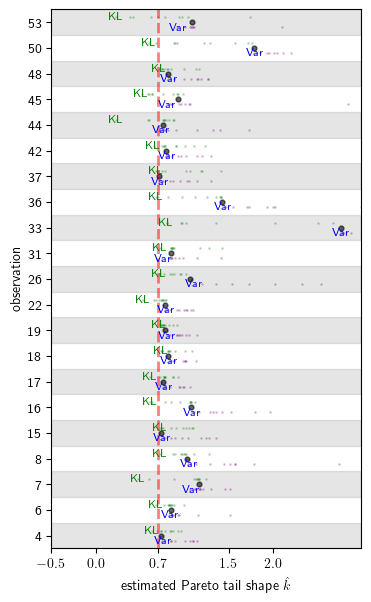

In [18]:
fig = plt.figure(figsize=(4, 7))
ndx_high_khat = loo['KL']['ndx'].tolist()
ymax = (len(ndx_high_khat))
_ = plt.scatter(original.khat, np.array([ndx_high_khat.index(i) for i in original['ndx']]) ,color="black", s=12, alpha=0.6)
_ = plt.scatter(kl_.khat, np.array([ndx_high_khat.index(i) for i in kl_['ndx']]) + 0.2, s=1, color='green', alpha=0.2)
_ = plt.scatter(var_.khat, np.array([ndx_high_khat.index(i) for i in var_['ndx']]) - 0.2, s=1, color='purple', alpha=0.2)

kl_ = kl_[kl_.khat<3]
ll_ = ll_[ll_.khat<3]
var_ = var_[var_.khat<3]
_ = plt.axvline(x=0.7, linestyle='dashed', linewidth=2, color='red', alpha=0.5)

kl_vals = defaultdict(list)
var_vals = defaultdict(list)
ll_vals = defaultdict(list)

for x, y, s in zip( kl_.khat, kl_['ndx'], kl_['rho_rank'].values.astype('int')):
    kl_vals[y] += [x]
    
for x, y, s in zip( var_.khat, var_['ndx'], var_['rho_rank'].values.astype('int')):
    var_vals[y] += [x]

for x, v in kl_vals.items():
    plt.plot(min(v), ndx_high_khat.index(x)+0.2, color='green', alpha=0.3)
    plt.text(min(v), ndx_high_khat.index(x) + 0.2, "KL",  ha='center', va='center', color='green', fontsize=8)
    
for x, v in var_vals.items():
    plt.plot(min(v), ndx_high_khat.index(x)-0.2, color='purple', alpha=0.3)
    plt.text(min(v), ndx_high_khat.index(x)-0.2, "Var",  ha='center', va='center', color='blue', fontsize=8)
    
    
#for x, v in var_vals.items():
#    plt.text(min(v), x, "LL",  ha='center', va='center', color='purple', fontsize=8)

_ = plt.ylabel("observation")
_ = plt.ylim(-0.5, ymax - 0.5)
_ = plt.xlabel(r'estimated Pareto tail shape $\hat{k}$')
_ = plt.yticks(ticks=np.arange(ymax), labels=loo['KL']['ndx'])
_ = plt.xlim((-0.5, 3))
_ = plt.xticks([-0.5, 0, 0.7, 1.5, 2])


for y0, y1 in zip(np.arange(ymax+ 1)[::2]-0.5, np.arange(ymax + 1)[::2] + 0.5):
    plt.axhspan(y0, y1, color='black', alpha=0.1, zorder=0)
#_ = plt.xlim((-0.1, 2))
_ = plt.savefig("khat_relu.pdf", bbox_inches='tight')

In [19]:
len(ndx_high_khat)

21

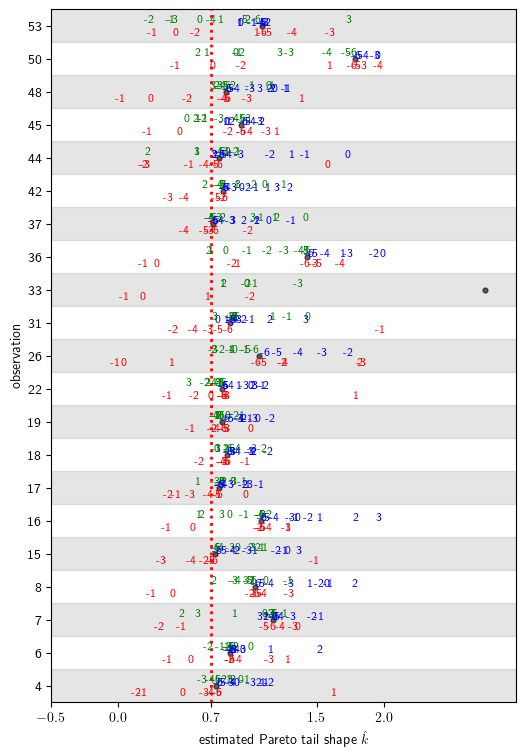

In [20]:
fig = plt.figure(figsize=(6, 9))

_ = plt.scatter(original.khat, np.array([ndx_high_khat.index(i) for i in original['ndx']]) ,color="black", s=12, alpha=0.6)
_ = plt.scatter(kl_.khat, np.array([ndx_high_khat.index(i) for i in kl_['ndx']]), s=0, color='green', alpha=0.2)
_ = plt.scatter(var_.khat, np.array([ndx_high_khat.index(i) for i in var_['ndx']]), s=0, color='purple', alpha=0.2)
_ = plt.scatter(ll_.khat, np.array([ndx_high_khat.index(i) for i in ll_['ndx']]), s=0, color='green', alpha=0.2)
_ = plt.scatter(mm1_.khat, np.array([ndx_high_khat.index(i) for i in mm1_['ndx']]), s=0, color='purple', alpha=0.2)

kl_ = kl_[kl_.khat<2]
ll_ = ll_[ll_.khat<2]
var_ = var_[var_.khat<2]
mm1_ = mm1_[mm1_.khat<2]
_ = plt.axvline(x=0.7, linestyle='dotted', linewidth=2, color='red')

for x, y, s in zip( kl_.khat, kl_['ndx'], kl_['rho_rank'].values.astype('int')):
    if s > 7:
        continue
    plt.text(x, ndx_high_khat.index(y) + 0.2, str(s),  ha='center', va='center', color='green', fontsize=8)
    
for x, y, s in zip( var_.khat, var_['ndx'], var_['rho_rank'].values.astype('int')):
    if s > 7:
        continue
    plt.text(x, ndx_high_khat.index(y) + 0.1, str(s),  ha='center', va='center', color='blue', fontsize=8)

for x, y, s in zip( ll_.khat, ll_['ndx'], ll_['rho_rank'].values.astype('int')):
    if s > 3:
        continue
    plt.text(x, ndx_high_khat.index(y) - 0.1, str(s),  ha='center', va='center', color='orange', fontsize=8)

for x, y, s in zip( mm1_.khat, mm1_['ndx'], mm1_['rho_rank'].values.astype('int')):
    if s > 3:
        continue
    plt.text(x, ndx_high_khat.index(y) - 0.2, str(s),  ha='center', va='center', color='red', fontsize=8)
    
_ = plt.ylabel("observation")
_ = plt.ylim(-0.5, ymax - 0.5)
_ = plt.xlabel(r'estimated Pareto tail shape $\hat{k}$')
_ = plt.yticks(ticks=np.arange(ymax), labels=loo['KL']['ndx'])
_ = plt.xlim((-0.5, 3))
_ = plt.xticks([-0.5, 0, 0.7, 1.5, 2])


for y0, y1 in zip(np.arange(ymax+ 1)[::2]-0.5, np.arange(ymax + 1)[::2] + 0.5):
    plt.axhspan(y0, y1, color='black', alpha=0.1, zorder=0)
#_ = plt.xlim((-0.1, 2))
_ = plt.savefig("khat_detailed_relu.pdf", bbox_inches='tight')

In [21]:
df_ = df.explode(['khat', "p_psis", 'ndx'])[['ndx', 'p_psis', 'khat', 'T']]
#df_ = df_[df_['p_psis']!=1]
#df_ = df_[df_['p_psis']>1e-5]
df_ = df_[df_['T']!="MM2"]

df_ = df_.groupby(['ndx'])[['khat', 'p_psis']].min()

pd.set_option('display.max_rows', 500)

df_ = df_.reset_index()
df_['y'] = [y_.tolist()[i][0] for i in df_['ndx'].values]


In [22]:
fpr, tpr, thresholds = metrics.roc_curve(df_['y'], df_.p_psis, pos_label=1)
precision, recall, thresholds_pr = metrics.precision_recall_curve(df_['y'], df_.p_psis)

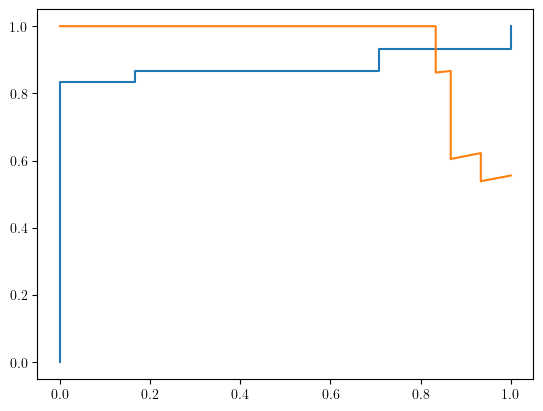

In [23]:
plt.plot(fpr, tpr)
plt.plot(recall, precision)

# Cross-tabulations

In [24]:
df__ = df.explode(['khat', 'ndx'])[['ndx', 'khat', 'T']]
transforms = ["KL", "Var", "LL", "MM1", "MM2"]


In [25]:
for T in transforms:
    _df__ = df__.loc[(df__['T']==T) & (df__['khat']<0.7)]
    print(f"{T}: {_df__.groupby('ndx').min().shape[0]}")
print(len(df__[df__['T']!="I0"].ndx.unique()))

KL: 13
Var: 0
LL: 0
MM1: 21
MM2: 21
21


In [26]:
print(f"{df__.loc[((df__['T']=='KL') | (df__['T']=='Var')) & (df__['khat']<0.7)].groupby('ndx').min().shape[0]}")

13


In [27]:
print(f"{df__.loc[((df__['T']=='LL') | (df__['T']=='MM1')) &(df__['T']!='I0') & (df__['khat']<0.7)].groupby('ndx').min().shape[0]}")

21


In [28]:
print(f"{df__.loc[(df__['T']!='MM1') &(df__['T']!='I0') & (df__['khat']<0.7)].groupby('ndx').min().shape[0]}")

21


In [29]:
len(df__[df__['T']!="I0"].ndx.unique())

21

# Compare with variational model

In [30]:
lr_model2 = ShallowGaussianRelunet(
    dim_regressors=d,
    hidden_size=3
)

In [ ]:

losses = lr_model2.fit(
    data_factory_factory(shuffle=True, repeat=True),
    dataset_size=N,
    batches_per_step=9,
    check_every=int(N/batch_size)*50,
    batch_size=batch_size,
    num_steps=2000,
    max_decay_steps=10,
    max_plateau_epochs=100,
    sample_size=36,
    learning_rate=0.001,
    lr_decay_factor=0.9
    )



Running optimization for 2000 steps of 9 accumulated batches, checking every 50 steps
Saved a checkpoint: /var/folders/9g/95lvk8690_52tvn55sr5m9nh0000gn/T/tfcheckpoints/df9798d3-e2b2-469f-8635-f2e82a6a6765/df9798d3-e2b2-469f-8635-f2e82a6a6765-1


  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
p_ = lr_model2.sample(5)
{k: p.shape for k, p in p_.items()}

{'w_1': TensorShape([5, 3, 1]),
 'w_0': TensorShape([5, 1536, 3]),
 'b_1': TensorShape([5, 1]),
 'b_0': TensorShape([5, 3])}

In [ ]:
base = 4
h_vals = [4**-r for r in range(9)]

loo_output = []

for _ in tqdm(range(1)):
    loo_khat_advi = {}
    reduced_ndx_advi = {}
    n_sample = [1000]
    records_advi = []
    for n_samples in n_sample:
        reduced_ndx_advi[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat_advi[n_samples] = {}
        params_ = lr_model2.sample(n_samples)

        for h in h_vals:
            loo_khat_advi[n_samples][h] = {}
            loo = adaptive_is_loo(lr_model2, batch, params_, h, variational=False)
            reduced_ndx_advi[n_samples][h] = {}
            # print(f"rho={h}\n")
            for T in ["I0", "I", "KL", "Var", "MM1", "MM2"]:
                loo_khat_advi[n_samples][h][T] = np.array(loo[T]["khat"])

                records_advi += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]["khat"],
                        "p_psis": loo[T]["p_psis"].numpy(),
                        "n>0.7": (np.where((loo[T]["khat"] > 0.7))[0]).shape,
                        "ndx": loo[T]["ndx"]
                    }
                ]
                reduced_ndx_advi[n_samples][h][T] = [loo[T]["ndx"][k] for k in np.where((loo[T]["khat"] <= 0.7))[0]]
                # print(reduced_ndx[n_samples][h])


print(reduced_ndx_advi)

100%|██████████| 1/1 [04:28<00:00, 268.80s/it]

{1000: {1: {'I0': [11, 21, 44, 45], 'I': [], 'KL': [49], 'Var': [49], 'MM1': [36, 49], 'MM2': []}, 0.25: {'I0': [11, 21, 44, 45], 'I': [], 'KL': [49], 'Var': [49], 'MM1': [7, 17, 26, 36, 40, 41, 49, 50, 53], 'MM2': [7, 36, 40, 49, 50, 53]}, 0.0625: {'I0': [11, 21, 44, 45], 'I': [], 'KL': [49], 'Var': [], 'MM1': [7, 17, 18, 19, 26, 27, 28, 32, 36, 37, 38, 39, 40, 41, 42, 43, 47, 49, 50, 52, 53], 'MM2': [7, 17, 18, 19, 26, 27, 28, 36, 37, 38, 39, 40, 41, 42, 43, 47, 49, 50, 52, 53]}, 0.015625: {'I0': [11, 21, 44, 45], 'I': [], 'KL': [], 'Var': [], 'MM1': [6, 7, 8, 16, 17, 18, 19, 22, 24, 25, 27, 33, 38, 39, 40, 41, 42, 43, 47, 49, 52, 53], 'MM2': [2, 6, 7, 8, 16, 17, 18, 19, 22, 24, 25, 26, 27, 28, 32, 33, 34, 36, 37, 38, 39, 41, 42, 43, 47, 48, 49, 50, 52, 53]}, 0.00390625: {'I0': [11, 21, 44, 45], 'I': [], 'KL': [], 'Var': [], 'MM1': [7, 16, 19, 27, 41, 43, 49, 53], 'MM2': [6, 7, 19, 41, 42, 43, 47, 53]}, 0.0009765625: {'I0': [11, 21, 44, 45], 'I': [], 'KL': [], 'Var': [], 'MM1': [49],

In [ ]:
df_advi = pd.DataFrame(records_advi)
df_advi['rho_rank'] = np.emath.logn(base, df_advi['h']) 

I0_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="I0")]

kl_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="KL")]
var_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="Var")]
ll_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="LL")]
mm1_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="MM1")]
I_advi = df_advi.loc[(df_advi['S']==n_sample[-1]) & (df_advi['T']=="I")]

kl_advi = kl_advi.explode(['khat', 'ndx'])
var_advi = var_advi.explode(['khat', 'ndx'])
ll_advi = ll_advi.explode(['khat', 'ndx'])
I_advi = I_advi.explode(['khat', 'ndx'])
mm1_advi = mm1_advi.explode(['khat', 'ndx'])

original_advi = I_advi[['khat', 'ndx']].drop_duplicates()


In [ ]:
df_advi_ = df_advi.explode(['khat', "p_psis", 'ndx'])[['ndx', 'p_psis', 'khat', 'T']]
#df_ = df_[df_['p_psis']!=1]
#df_ = df_[df_['p_psis']>1e-5]
df_advi_ = df_advi_[df_advi_['T']!="MM2"]

df_advi_ = df_advi_.groupby(['ndx'])[['khat', 'p_psis']].min()

pd.set_option('display.max_rows', 500)

df_advi_ = df_advi_.reset_index()
df_advi_['y'] = [y_.tolist()[i][0] for i in df_advi_['ndx'].values]

In [ ]:
fpr_advi, tpr_advi, thresholds_advi = metrics.roc_curve(df_advi_['y'], df_advi_.p_psis, pos_label=1)
precision_advi, recall_advi, thresholds_pr_advi = metrics.precision_recall_curve(df_advi_['y'], df_advi_.p_psis)

NameError: name 'fpr' is not defined

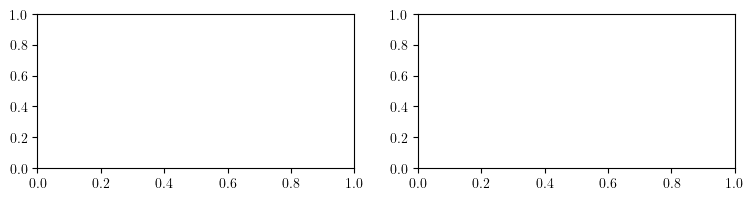

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2))
ax[0].plot(fpr, tpr, linewidth=3, color="blue")
ax[0].text(0.5, 0.25, f"MCMC-AUROC: {metrics.auc(fpr, tpr):.3f}", color="blue")

ax[0].plot(fpr_advi, tpr_advi, color="red")
ax[0].text(0.5, 0.1, f"ADVI-AUROC: {metrics.auc(fpr_advi, tpr_advi):.3f}", color="red")

ax[0].set_xlim((0, 1))
ax[0].set_ylim((0, 1))
ax[0].set_title("ROC")

ax[1].plot(recall, precision, linewidth=3, color="blue")
ax[1].plot(recall_advi, precision_advi, color="red")
ax[1].text(0.5, 0.8, f"MCMC-AUPRC: {metrics.auc(recall, precision):.3f}", color="blue")
ax[1].text(0.5, 0.65, f"ADVI-AUPRC: {metrics.auc(recall_advi, precision_advi):.3f}", color="red")
ax[1].set_title("Precision-Recall")
ax[1].set_xlim((0, 1))
ax[1].set_ylim((0, 1))

_ = plt.savefig("roccurve_relu.pdf", bbox_inches='tight')

In [ ]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)  # allows duplicate elements
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [ ]:
base = 4
h_vals = [base**-r for r in range(-2, 8)]

loo_output = []
success = []

for _ in tqdm(range(10)):
    loo_khat = {}
    reduced_ndx = {}
    high_khat_ndx = {}
    n_sample = [1000]
    records = []
    for n_samples in n_sample:
        sample_ndx = np.random.choice(
            range(params["b_0"].shape[0]), size=n_samples, replace=False
        )
        reduced_ndx[n_samples] = {}
        high_khat_ndx[n_samples] = {}
        # print(f"Samples: {n_samples}")
        loo_khat[n_samples] = {}

        params_ = {k: v.numpy()[sample_ndx] for k, v in params.items()}

        for h in h_vals:
            loo_khat[n_samples][h] = {}
            loo = adaptive_is_loo(nn_model, batch, params_, h, variational=False)
            reduced_ndx[n_samples][h] = {}
            # print(f"rho={h}\n")
            for T in ["I0", "I",  "KL", "Var", "MM1", "MM2"]:
                loo_khat[n_samples][h][T] = np.array(loo[T]["khat"])

                records += [
                    {
                        "h": h,
                        "T": T,
                        "S": n_samples,
                        "khat": loo[T]["khat"],
                        "p_psis": loo[T]["p_psis"].numpy(),
                        "n>0.7": (np.where((loo[T]["khat"] > 0.7))[0]).shape,
                        "ndx": loo[T]["ndx"],
                    }
                ]
                reduced_ndx[n_samples][h][T] = [
                    loo[T]["ndx"][k] for k in np.where((loo[T]["khat"] <= 0.7))[0]
                ]
                # print(reduced_ndx[n_samples][h])

    df = pd.DataFrame(records)
    df["rho_rank"] = np.emath.logn(base, df["h"])
    __df__ = df.explode(["khat", "ndx"])[["ndx", "khat", "T"]]

    counts = {}
    counts["n"] = len(__df__[__df__["T"] != "I0"].ndx.unique())
    for T in transforms:
        ___df__ = __df__.loc[(__df__["T"] == T) & (__df__["khat"] < 0.7)]
        counts[T] = ___df__.groupby("ndx").min().shape[0]
    ___df__ = __df__.loc[
        ((__df__["T"] == "KL") | (__df__["T"] == "Var")) & (__df__["khat"] < 0.7)
    ]
    counts[("KL", "Var")] = ___df__.groupby("ndx").min().shape[0]
    ___df__ = __df__.loc[
        ((__df__["T"] == "MM1") | (__df__["T"] == "MM2") | (__df__["T"] == "LL"))
        & (__df__["khat"] < 0.7)
    ]
    counts[("MM1", "MM2")] = ___df__.groupby("ndx").min().shape[0]
    ___df__ = __df__.loc[
        ((__df__["T"] == "MM1") | (__df__["T"] == "MM2") |  (__df__["T"] == "KL") | (__df__["T"] == "Var"))
        & (__df__["khat"] < 0.7)
    ]
    counts[("KL", "Var", "MM1", "MM2")] = ___df__.groupby("ndx").min().shape[0]
    success += [counts]

100%|██████████| 10/10 [24:07<00:00, 144.76s/it]


In [ ]:
success = pd.DataFrame(success)
success_ = success.copy()
success_.iloc[:, 1:] = -success_.iloc[:, 1:].sub(success_.iloc[:, 0], axis=1)

/tmp/ipykernel_1898243/438181115.py:3: RuntimeWarning: '<' not supported between instances of 'int' and 'tuple', sort order is undefined for incomparable objects.
  success_.iloc[:, 1:] = -success_.iloc[:, 1:].sub(success_.iloc[:, 0], axis=1)
/tmp/ipykernel_1898243/438181115.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: KL, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  success_.iloc[:, 1:] = -success_.iloc[:, 1:].sub(success_.iloc[:, 0], axis=1)
/tmp/ipykernel_1898243/438181115.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
7   NaN
8   NaN
9   NaN
Name: Var, dtype: float64' has dtype incompatible with int64, please explicitly cast to a 

In [ ]:
success.agg(['mean','std'])

,n,KL,Var,LL,MM1,MM2,"(KL, Var)","(MM1, MM2)","(KL, Var, MM1, MM2)"
mean,18.500000,10.000000,1.600000,0.0,17.900000,18.500000,10.700000,18.500000,18.500000
std,1.900292,1.632993,1.505545,0.0,2.469818,1.900292,1.702939,1.900292,1.900292


In [ ]:
(-success.iloc[:, 1:].sub(success.iloc[:, 0], axis=0)).agg(['mean','std'])

,KL,Var,LL,MM1,MM2,"(KL, Var)","(MM1, MM2)","(KL, Var, MM1, MM2)"
mean,8.500000,16.900000,18.500000,0.600000,0.0,7.800000,0.0,0.0
std,1.354006,2.378141,1.900292,0.699206,0.0,0.918937,0.0,0.0


In [ ]:
_df = df.explode(['khat','ndx'])[['rho_rank', 'T', 'ndx', 'khat']]
_df['rho_rank'] *= -1

In [ ]:
base_khat = _df[_df['T']=="I"][['ndx', 'khat']].drop_duplicates().to_dict(orient='records')
base_khat = {r['ndx']: r['khat'] for r in base_khat}


In [ ]:
_df = _df[(_df["T"]!="I") & (_df["T"]!="I0")]
_df[r'$\log(\hat{k}/\hat{k}_0)$'] = _df.apply(lambda x: x.khat/base_khat[x.ndx], axis=1)
_df[r'$-log_4(\rho)$'] = _df['rho_rank']

In [ ]:
_df = _df[_df[r'$\log(\hat{k}/\hat{k}_0)$']<4]

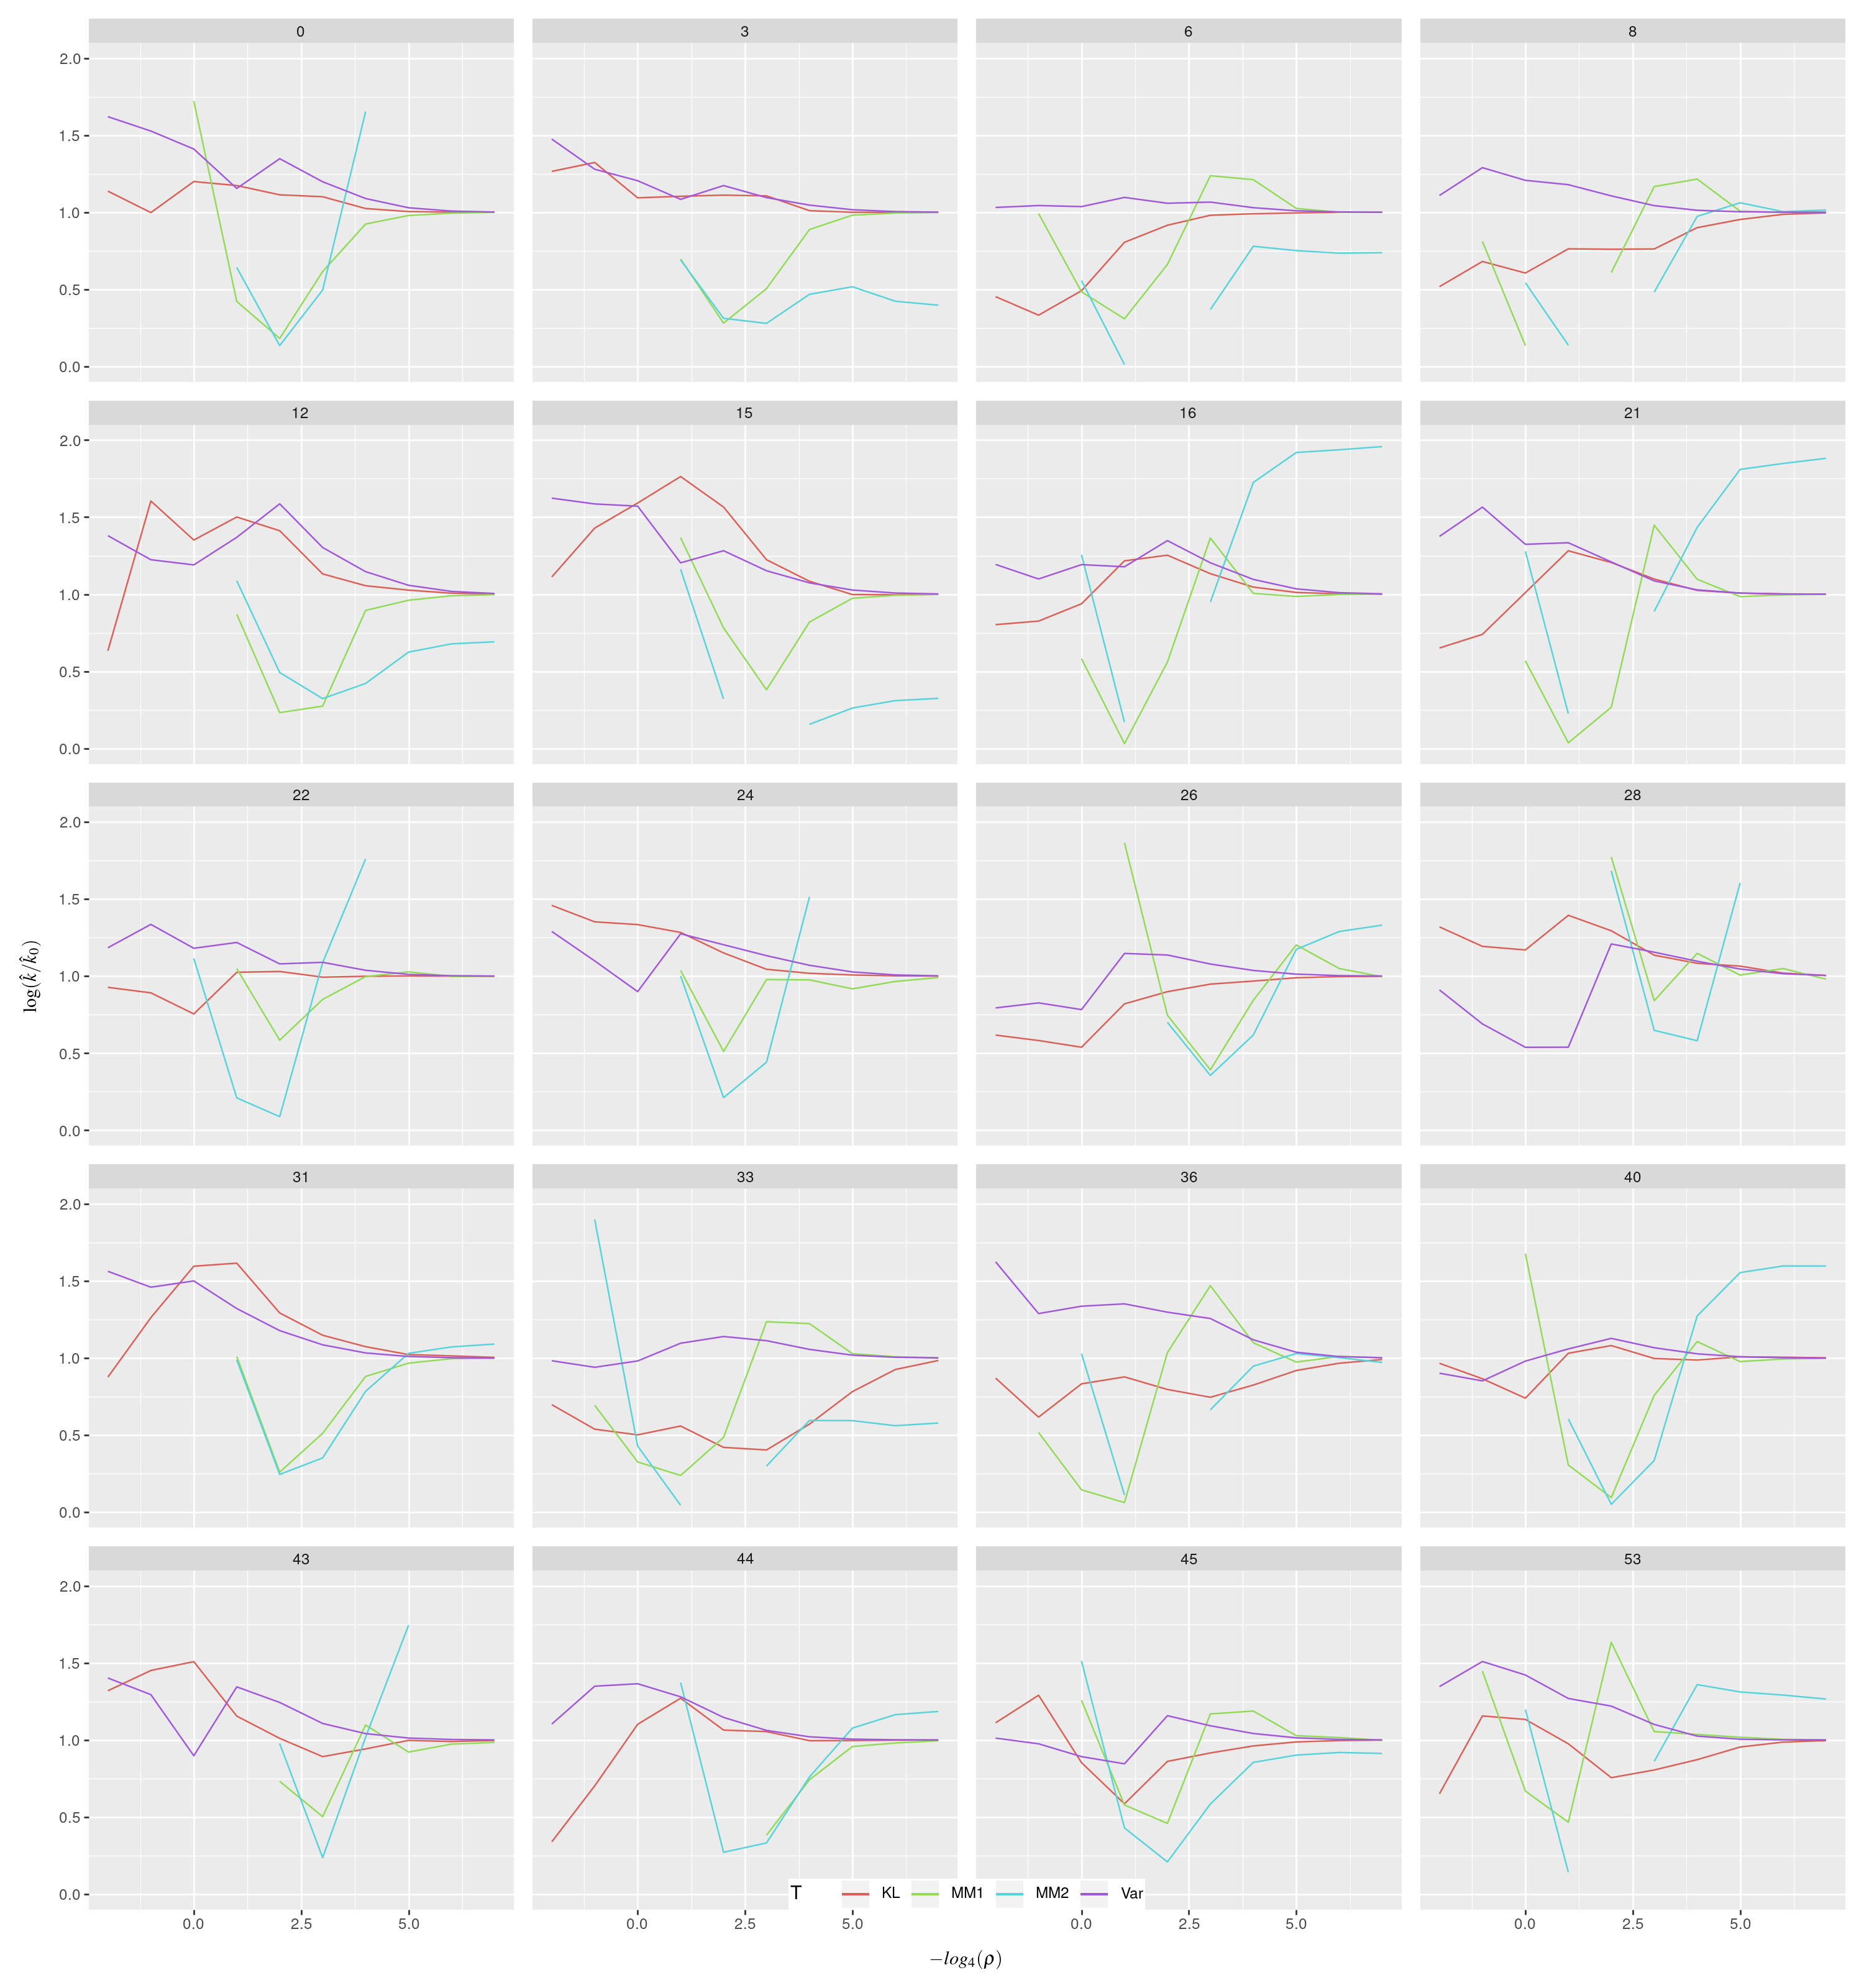

/home/josh/workspace/readmission/env/lib/python3.10/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 15 x 16 in image.
/home/josh/workspace/readmission/env/lib/python3.10/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: rho_rank_relu.pdf


In [ ]:
from plotnine import ggplot, geom_line, geom_point, aes, stat_smooth, facet_wrap, theme, ylim
from plotnine.data import mtcars


plot = (
    ggplot(_df, aes(r'$-log_4(\rho)$', r'$\log(\hat{k}/\hat{k}_0)$', color="T"))
    + geom_line()
    + facet_wrap("ndx", ncol=4)
    + theme(figure_size=(15, 16), legend_position=(.5, .0), legend_direction='horizontal') + ylim((0, 2))
    
)
plot.show()
plot.save("rho_rank_relu.pdf")